# Extended Flexible Job-shop Scheduling Problem

This notebook uses CP Optimizer to solve the Extended Flexible Job-shop Scheduling Problem (EFJS).

Let $o$ and $m$ be respectively the number of operations and machines. Let $V=\{1,2,...,o\}$ be the set of all operations.  For each operation $i \in V$, let $F_i \subseteq \{1,2,...,m\}$, where $F_i \neq \emptyset$ be the subset of machines that can process operation $i$ and let $p_{ik}$ ($i \in V,k \in F_i$) be the processing time of operation $i$ if it is executed on machine $k$.  Furthermore, let $A$ be a set of pairs $(i,j)$ with $i,j \in V$ such  that, if $(i,j)$ belongs to $A$, this means that operation $i$ precedes operation $j$, i.e.  operation $j$ cannot start to be processed until operation $i$ finishes processing.  This set of precedences $A$ is the place where jobs are implicitly defined.  The problem consists in assigning each operation $i$ to a machine $k \in F_i$ and to determine a starting processing time $s_i$ such that precedences are satisfied.  A machine can not process more than one operation at a time and preemption is not allowed.  The objective is to minimize the makespan.

# Reading the data

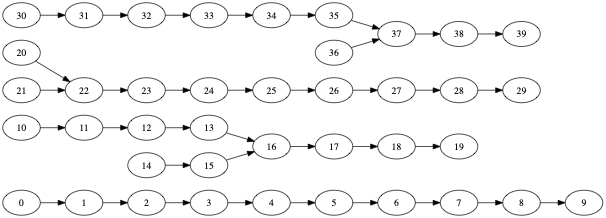

In [1]:
# This is instance YFJS/YFJS01
o = 40
m = 7
V = range(o)
M = range(m)
A = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (10, 11), (11, 12), (12, 13), (13, 16), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (20, 22), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 37), (36, 37), (37, 38), (38, 39)]
F = [[(0, 92), (2, 28), (6, 159)], [(2, 61), (4, 136)], [(2, 71), (3, 196)], [(1, 93), (2, 29), (6, 124)], [(2, 141), (3, 150)], [(1, 153), (3, 195), (4, 139)], [(1, 83), (2, 45), (4, 195)], [(2, 124), (6, 23)], [(0, 106), (1, 46), (3, 134)], [(2, 37), (3, 133), (6, 52)], [(0, 137), (2, 160), (3, 157)], [(0, 33), (2, 20), (3, 153)], [(1, 198), (5, 78)], [(1, 172), (2, 54), (3, 187)], [(2, 193), (5, 136)], [(2, 163), (3, 198), (6, 178)], [(4, 22), (6, 122)], [(0, 63), (2, 41), (6, 174)], [(0, 153), (3, 113), (6, 116)], [(0, 174), (2, 34), (4, 68)], [(2, 77), (5, 199)], [(4, 192), (6, 109)], [(1, 131), (5, 99), (6, 147)], [(2, 39), (4, 38), (5, 83)], [(2, 172)], [(4, 89), (5, 99), (6, 109)], [(2, 24), (5, 87)], [(0, 129), (2, 120)], [(2, 132), (3, 25), (4, 197)], [(3, 42), (5, 176), (6, 194)], [(0, 154), (3, 82), (5, 135)], [(2, 119), (5, 53)], [(2, 125), (3, 59), (6, 28)], [(0, 26), (2, 35), (4, 27)], [(2, 191), (4, 95), (6, 93)], [(0, 50), (2, 58), (4, 176)], [(2, 30), (4, 76)], [(2, 150), (4, 179)], [(2, 180), (3, 38), (6, 125)], [(0, 71), (1, 168), (4, 194)]]

# Display precedence graph between operations
import networkx as nx
from nxpd import draw
G = nx.DiGraph(A,rankdir='LR',dpi=50)
draw(G,show='ipynb')

# Modeling the problem with CP Optimizer

In [2]:
# Import CP Optimizer modelization functions
from docplex.cp.model import *

# Create model object
model = CpoModel()

# Decision variables: o[i] is operation i
o = [interval_var() for i in V ] 

# Decision variables: a[i][k] is operation i on machine k
a = [{k:interval_var(optional=True,size=p) for k,p in F[i]} for i in V] 

# Objective: minimize makespan
model.add(minimize(max(end_of(o[i]) for i in V)))

# Constraints: precedence constraints
model.add([end_before_start(o[i],o[j]) for i,j in A])

# Constraints: machine allocation
model.add([alternative(o[i], a[i].values()) for i in V])

# Constraints: machines are unary resources
model.add([no_overlap([a[i][k] for i in V if k in a[i]]) for k in M])

# Solving the problem with CP Optimizer automatic search

The model can be solved by calling CP Optimizer's automatic search:

In [3]:
# Solve the model
sol = model.solve(trace_log=True,LogPeriod=1000000)

 ! ----------------------------------------------------------------------------
 ! Minimization problem - 151 variables, 83 constraints
 ! LogPeriod            = 1000000
 ! Initial process time : 0.00s (0.00s extraction + 0.00s propagation)
 !  . Log search space  : 465.8 (before), 465.8 (after)
 !  . Memory usage      : 914.8 kB (before), 914.8 kB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0        151                 -
 + New bound is 718
 ! Using iterative diving.
 *          1766      147  0.10s        1      (gap is 59.34%)
 *          1707      229  0.10s        1      (gap is 57.94%)
 *          1701      311  0.10s        1      (gap is 57.79%)
 *          1501      393  0.10s        1      (gap is 52.17%)
 *          1427      475  0.10s        1      (gap is 49.68%)
 *          1425      557  0.10s       

# Displaying the solution

In [4]:
import docplex.cp.utils_visu as visu
visu.panel("Machines")
for k in M:
    visu.sequence("M" + str(k))
    for i in V:
        if k in a[i] and sol.get_var_solution(a[i][k]).is_present():
            visu.interval(sol.get_var_solution(o[i]), i//10, str(i))
visu.show()

<Figure size 640x480 with 1 Axes>